好的，我们可以从Gym库中选择另一个环境来实现非典型Q-学习和双Q学习算法。我们选择经典的“Taxi-v3”环境，这个环境是一个典型的强化学习问题，其中出租车需要接载乘客并将其送到目的地。

下面是基于非典型Q-学习和双Q学习算法的实现代码：

#第一步：安装并导入必要的库
#Шаг 1: Установите и импортируйте необходимые библиотеки

In [9]:
import numpy as np
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt
from pprint import pprint

# 第二步：定义基础代理类
# 定义基础代理类，其他学习策略从该类继承
# Определите базовый прокси-класс, и другие стратегии обучения будут наследоваться от этого класса

In [10]:
class BasicAgent:
    '''
    基础代理类，其他学习策略从该类继承
    '''
    ALGO_NAME = '---'

    def __init__(self, env, eps=0.1):
        self.env = env
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        self.Q = np.zeros((self.nS, self.nA))
        self.eps = eps
        self.episodes_reward = []

    def print_q(self):
        print(f'算法 {self.ALGO_NAME} 的 Q 矩阵:')
        print(self.Q)

    def get_state(self, state):
        return state

    def greedy(self, state):
        return np.argmax(self.Q[state])

    def make_action(self, state):
        if np.random.uniform(0, 1) < self.eps:
            return self.env.action_space.sample()
        else:
            return self.greedy(state)

    def draw_episodes_reward(self):
        fig, ax = plt.subplots(figsize=(15, 10))
        y = self.episodes_reward
        x = list(range(1, len(y) + 1))
        plt.plot(x, y, '-', linewidth=1, color='green')
        plt.title('每个回合的奖励')
        plt.xlabel('回合编号')
        plt.ylabel('奖励')
        plt.show()

    def learn(self):
        pass


# 定义SARSA代理类，基于SARSA算法的实现
# Определите класс прокси-сервера SARSA на основе реализации алгоритма SARSA


In [11]:
class SARSA_Agent(BasicAgent):
    ALGO_NAME = 'SARSA'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        super().__init__(env, eps)
        self.lr = lr
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def learn(self):
        self.episodes_reward = []
        for ep in tqdm(range(self.num_episodes)):
            state = self.get_state(self.env.reset())
            done = False
            tot_rew = 0
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay
            action = self.make_action(state)
            while not done:
                next_state, rew, done, _ = self.env.step(action)
                next_action = self.make_action(next_state)
                self.Q[state][action] = self.Q[state][action] + self.lr * (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])
                state = next_state
                action = next_action
                tot_rew += rew
                if done:
                    self.episodes_reward.append(tot_rew)


# 定义Q学习代理类，基于Q学习算法的实现
# Определите класс Q learning agent на основе реализации алгоритма Q learning

In [12]:
class QLearning_Agent(BasicAgent):
    ALGO_NAME = 'Q-学习'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        super().__init__(env, eps)
        self.lr = lr
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def learn(self):
        self.episodes_reward = []
        for ep in tqdm(range(self.num_episodes)):
            state = self.get_state(self.env.reset())
            done = False
            tot_rew = 0
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay
            while not done:
                action = self.make_action(state)
                next_state, rew, done, _ = self.env.step(action)
                self.Q[state][action] = self.Q[state][action] + self.lr * (rew + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])
                state = next_state
                tot_rew += rew
                if done:
                    self.episodes_reward.append(tot_rew)


# 定义双重Q学习代理类，基于双重Q学习算法的实现
# Определите класс обучающего агента dual Q на основе реализации алгоритма обучения dual Q

In [13]:
class DoubleQLearning_Agent(BasicAgent):
    ALGO_NAME = '双重Q-学习'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        super().__init__(env, eps)
        self.Q2 = np.zeros((self.nS, self.nA))
        self.lr = lr
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def greedy(self, state):
        temp_q = self.Q[state] + self.Q2[state]
        return np.argmax(temp_q)

    def print_q(self):
        print(f'算法 {self.ALGO_NAME} 的 Q 矩阵:')
        print('Q1')
        print(self.Q)
        print('Q2')
        print(self.Q2)

    def learn(self):
        self.episodes_reward = []
        for ep in tqdm(range(self.num_episodes)):
            state = self.get_state(self.env.reset())
            done = False
            tot_rew = 0
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay
            while not done:
                action = self.make_action(state)
                next_state, rew, done, _ = self.env.step(action)
                if np.random.rand() < 0.5:
                    self.Q[state][action] = self.Q[state][action] + self.lr * (rew + self.gamma * self.Q2[next_state][np.argmax(self.Q[next_state])] - self.Q[state][action])
                else:
                    self.Q2[state][action] = self.Q2[state][action] + self.lr * (rew + self.gamma * self.Q[next_state][np.argmax(self.Q2[next_state])] - self.Q2[state][action])
                state = next_state
                tot_rew += rew
                if done:
                    self.episodes_reward.append(tot_rew)


# 定义方法运行和显示训练好的代理
# Определите метод запуска и отображения обученного агента

In [14]:
def play_agent(agent):
    env2 = gym.make('Taxi-v3', render_mode='human')
    state = env2.reset()
    done = False
    while not done:
        action = agent.greedy(state)
        next_state, reward, done, info = env2.step(action)
        env2.render()
        state = next_state
        if done:
            break


# 定义运行SARSA、Q学习和双重Q学习代理的方法
# Определите методы для запуска агентов SARSA, Q learning и dual Q learning agents

In [15]:
def run_sarsa():
    env = gym.make('Taxi-v3')
    agent = SARSA_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

def run_q_learning():
    env = gym.make('Taxi-v3')
    agent = QLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

def run_double_q_learning():
    env = gym.make('Taxi-v3')
    agent = DoubleQLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)


# 运行主函数，选择运行哪种代理
# Запустите основную функцию и выберите, какой агент запускать

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/20000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 20000/20000 [00:23<00:00, 862.86it/s] 
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWa

算法 双重Q-学习 的 Q 矩阵:
Q1
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.51066287  0.51002369 -0.13061655  2.7939699   8.36234335 -7.10470425]
 [ 8.27637432  8.78539485  4.67156992  7.90314757 13.27445578 -0.45068865]
 ...
 [ 0.25889404  8.03308315 -0.90895983 -0.90428159 -5.2335591  -4.49459473]
 [-3.022162   -3.38901681 -3.42256211  5.90133081 -8.20703158 -9.38207663]
 [ 4.88553251  2.37091516  4.92736922 18.16795919 -1.13703923  0.1729733 ]]
Q2
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.85260744  2.92278209  1.15565913  4.14808952  8.36234335 -6.50377254]
 [ 7.14459278  6.94483058  4.29405889  6.33704975 13.27445578 -0.25166995]
 ...
 [-1.92822355 10.19797867 -1.84452221 -1.14228828 -4.84618423 -1.35994625]
 [-3.40497916 -2.44978528 -2.68411501  6.42852127 -5.25279208 -8.56224652]
 [ 2.11662199  4.348063    2.28165494 18.29406667  0.08291456 -0.24947801]]


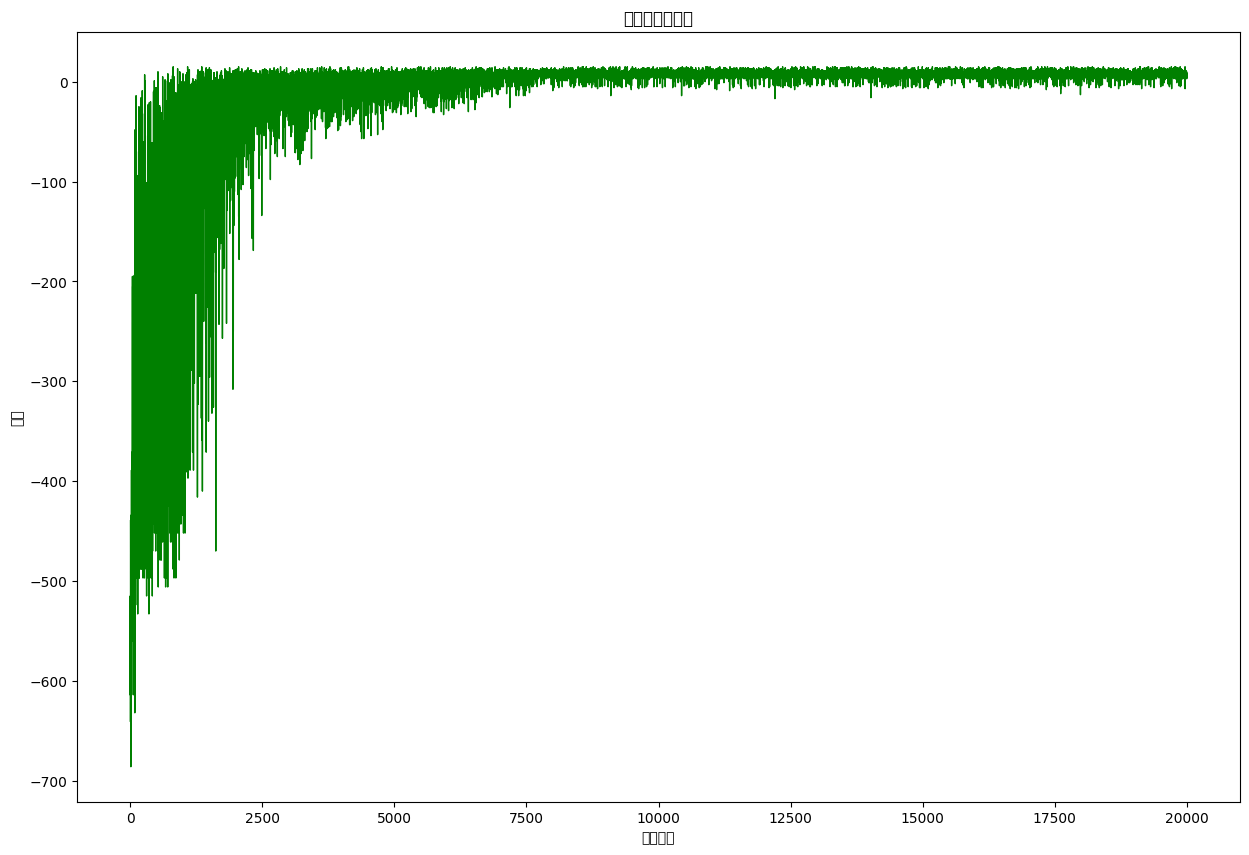

In [16]:
def main():
    # run_sarsa()
    # run_q_learning()
    run_double_q_learning()

if __name__ == '__main__':
    main()
